In [1]:
# import wget
import os
import glob
import random
import numpy as np
import os,shutil
import matplotlib 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from os import listdir
from torch.utils import data
from torch.utils.data import DataLoader
from skimage.transform import resize
from IPython.display import clear_output
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import imgaug.augmenters as iaa

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
newdir = '/content/drive/My Drive/Gland_SegNet'

mydir ='/content/drive/My Drive/Colab Notebooks/Raw Dataset'
pathDir = os.listdir(mydir) 

In [0]:
# separate dataset to 3 class : testA, test B, train and its masks.
testsetA = []
testsetB = []
trainset = []
testmaskA = []
testmaskB = []
trainmask = []

for allDir in pathDir:      
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==True:     
        testmaskA.append(allDir)
        
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==False:
        testsetA.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==True:       
        testmaskB.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==False:
        testsetB.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==True:        
        trainmask.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==False:        
        trainset.append(allDir)

#Build new dataset root
raw_img_train_location = newdir+os.sep+'train'+os.sep+'raw'
raw_img_testA_location = newdir+os.sep+'testA'+os.sep+'raw'
raw_img_testB_location = newdir+os.sep+'testB'+os.sep+'raw'
anno_img_train_location = newdir+os.sep+'train'+os.sep+'anno'
anno_img_testA_location = newdir+os.sep+'testA'+os.sep+'anno'
anno_img_testB_location = newdir+os.sep+'testB'+os.sep+'anno'

if not os.path.isdir(raw_img_train_location):
    os.makedirs(raw_img_train_location)
if not os.path.isdir(raw_img_testA_location):
    os.makedirs(raw_img_testA_location)
if not os.path.isdir(raw_img_testB_location):
    os.makedirs(raw_img_testB_location)

if not os.path.isdir(anno_img_train_location):
    os.makedirs(anno_img_train_location)
if not os.path.isdir(anno_img_testA_location):
    os.makedirs(anno_img_testA_location)
if not os.path.isdir(anno_img_testB_location):
    os.makedirs(anno_img_testB_location)

def copy_img(path,list):
    for i in range(len(list)):
        new_obj_name = list[i]
        shutil.copy(mydir+'/'+new_obj_name,path+'/'+new_obj_name)

copy_img(raw_img_train_location,trainset)
copy_img(raw_img_testA_location,testsetA) 
copy_img(raw_img_testB_location,testsetB)
copy_img(anno_img_train_location,trainmask)
copy_img(anno_img_testA_location,testmaskA)
copy_img(anno_img_testB_location,testmaskB)

In [0]:
# sort the dataset to make raw images and its masks are corresponding.
imgsize_w=256

def namesort(path,way):
    # 0 for raw, 1 for anno
    labelList = []  
    datasetList = listdir(path)
    datasetload = []
    if way==0:
        list.sort(datasetList,key=lambda x: int(x[6:-4]))
    else:
        list.sort(datasetList,key=lambda x: int(x[6:-9]))
    for i in range(len(datasetList)):
        temp=imread(path+"/"+datasetList[i])
        datasetload.append(temp)
    return datasetList,datasetload


def newchannel(anno2,num_of_classes=2):
    #anno: one anno image
    anno = anno2.reshape((imgsize_w,imgsize_w))
    anno[anno>0] = 1
    
    anno_reshaped = np.zeros((anno.shape[0], anno.shape[1], num_of_classes))
    # print(anno_reshaped)
    # print(anno_reshaped[:, :, 0])
    for i in range(num_of_classes):
        anno_reshaped[:, :, i][anno == i] = 1

    return anno_reshaped


class Custom_Data(data.Dataset):
    def __init__(self, path_train, path_anno, transform = None):
        # sorted data list
        (raw_img_list,raw_img) = namesort(path_train,0)
        (anno_img_list,anno_img) = namesort(path_anno,1)
        raw_img_lists = [os.path.join(path_train, img) for img in raw_img_list]
        anno_img_lists = [os.path.join(path_anno, img) for img in anno_img_list]
        self.raw_img_lists = raw_img_lists
        self.anno_img_lists = anno_img_lists
        # self.transform = transform

    def __len__(self):
        return len(self.raw_img_lists)
    
    def transform(self, image, mask):
   
        angle = transforms.RandomRotation.get_params([-180, 180])

        image = tf.rotate(image, angle, resample=Image.NEAREST)
        mask = tf.rotate(mask, angle, resample=Image.NEAREST)
   
        if random.random() > 0.5:
            image = tf.hflip(image)
            mask = tf.hflip(mask)
        if random.random() > 0.5:
            image = tf.vflip(image)
            mask = tf.vflip(mask)
     
        # if random.random() > 0.5:
        i, j, h, w = transforms.RandomResizedCrop.get_params(
            image, scale=(0.25, 1.0), ratio=(1, 1))
        
        image = tf.resized_crop(image, i, j, h, w, imgsize_w)
        mask = tf.resized_crop(mask, i, j, h, w, imgsize_w)
        # else:
        #     pad = random.randint(0, 192)
        #     image = tf.pad(image, pad)
        #     image = tf.resize(image, 256)
        #     mask = tf.pad(mask, pad)
        #     mask = tf.resize(mask, 256)

        image = tf.to_tensor(image)
        #image = transforms.Normalize(image, [0.5], [0.5])
        mask = tf.to_tensor(mask)
        #mask = transforms.Normalize(mask, [0.5], [0.5])
        return image, mask
# new normalization using rgbaverage  ,std , divided
    def __getitem__(self,index,plots=False):
        #get image at index
        raw_img_path = self.raw_img_lists[index]
        raw_img_one = Image.open(raw_img_path)
        # raw_imgs = self.transform(raw_img_one)
        
        anno_img_path = self.anno_img_lists[index]
        anno_img_one = Image.open(anno_img_path).convert("L")
        # anno_img_reshaped = self.transform(anno_img_one)
        raw_imgs, anno_img_reshaped = self.transform(raw_img_one, anno_img_one)
        raw_img_show = raw_imgs.permute(1,2,0)
      
        anno_img_reshaped = anno_img_reshaped.numpy()
        anno_img_reshaped = newchannel(anno_img_reshaped)
        
        anno_img_show = torch.from_numpy(anno_img_reshaped)
        anno_img_reshaped = anno_img_show.permute(2,0,1)
        # anno_img_show = anno_img_reshaped.permute(1,2,0)
        # anno_img_show = torch.squeeze(anno_img_show,2)
    
        if plots:
            plt.figure()
            plt.subplot(3,1,1)
            plt.imshow(raw_img_show)
            plt.subplot(3,1,2)
            plt.imshow(anno_img_show[:,:,0])
            plt.subplot(3,1,3)
            plt.imshow(anno_img_show[:,:,1])
            plt.show()

        return (raw_imgs,anno_img_reshaped)

train_data = Custom_Data(raw_img_train_location, anno_img_train_location)
testplot = train_data.__getitem__(8)
# print(data_len)

In [0]:
class Custom_Data_test(data.Dataset):
    def __init__(self, path_train, path_anno):
        # sorted data list
        (raw_img_list,raw_img) = namesort(path_train,0)
        (anno_img_list,anno_img) = namesort(path_anno,1)
        raw_img_lists = [os.path.join(path_train, img) for img in raw_img_list]
        anno_img_lists = [os.path.join(path_anno, img) for img in anno_img_list]
        self.raw_img_lists = raw_img_lists
        self.anno_img_lists = anno_img_lists
        # self.transform = transform

    def __len__(self):
        return len(self.raw_img_lists)
    
    def __getitem__(self,index,plots=False):
        #get image at index

        raw_img_path = self.raw_img_lists[index]
        raw_img_one = Image.open(raw_img_path)
        # raw_imgs = self.transform(raw_img_one)
        raw_imgs = transforms.Resize((imgsize_w,imgsize_w))(raw_img_one)
        anno_img_path = self.anno_img_lists[index]
        anno_img_one = Image.open(anno_img_path).convert("L")
        # anno_img_reshaped = self.transform(anno_img_one)
        anno_img_reshaped = transforms.Resize((imgsize_w,imgsize_w))(anno_img_one)
        raw_imgs = np.array(raw_imgs)
        raw_imgs = transforms.ToTensor()(raw_imgs)
        raw_img_show = raw_imgs.permute(1,2,0)
      
        anno_img_reshaped = np.array(anno_img_reshaped)
        anno_img_reshaped = newchannel(anno_img_reshaped)
        anno_img_reshaped = transforms.ToTensor()(anno_img_reshaped)
        anno_img_show = anno_img_reshaped.permute(1,2,0)
        # anno_img_show = torch.from_numpy(anno_img_reshaped)
        # anno_img_reshaped = anno_img_show.permute(2,0,1)
   
        if plots:
            plt.figure()
            plt.subplot(3,1,1)
            plt.imshow(raw_img_show)
            plt.subplot(3,1,2)
            plt.imshow(anno_img_show[:,:,0])
            plt.subplot(3,1,3)
            plt.imshow(anno_img_show[:,:,1])
            plt.show()

        return (raw_imgs,anno_img_reshaped)

vail_data = Custom_Data_test(raw_img_testA_location, anno_img_testA_location)
test_data = Custom_Data_test(raw_img_testB_location, anno_img_testB_location)
# test_plot = test_data.__getitem__(8)


In [0]:
class SegNetBasic(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.enc_conv0.weight)
        self.bn0=nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)

        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.enc_conv1.weight)
        self.bn1=nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)

        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.enc_conv2.weight)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)

        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.enc_conv3.weight)
        self.bn3=nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.dec_conv0.weight)
        self.bn_dec0=nn.BatchNorm2d(64)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.dec_conv1.weight)
        self.bn_dec1=nn.BatchNorm2d(64)
        self.upsample2 = nn.Upsample(64)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        nn.init.kaiming_uniform_(self.dec_conv2.weight)
        self.bn_dec2=nn.BatchNorm2d(64)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 2, 3, padding=1)
        nn.init.kaiming_uniform_(self.dec_conv3.weight)
        self.bn_dec3=nn.BatchNorm2d(64)
        
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.bn_dec0(self.upsample0(b))))
        d1 = F.relu(self.dec_conv1(self.bn_dec1(self.upsample1(d0))))
        d2 = F.relu(self.dec_conv2(self.bn_dec2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.bn_dec3(self.upsample3(d2)) ) # no activation
        d3 = torch.softmax(d3,dim=1)
        return d3
    
    

In [0]:
class Encode_conv_bn_x2(nn.Module):
    def __init__(self, in_, out):
        super(Encode_conv_bn_x2, self).__init__()
        batchNorm_momentum = 0.1
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)
        self.conv2 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x    
    
class Encode_conv_bn_x3(nn.Module):
    def __init__(self, in_, out):
        super(Encode_conv_bn_x3, self).__init__()
        batchNorm_momentum = 0.1
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)
        self.conv2 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)
        self.conv3 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class Dencode_conv_bn_x1(nn.Module):
    def __init__(self, in_, out):
        super(Dencode_conv_bn_x1, self).__init__()
        batchNorm_momentum = 0.1
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_, momentum= batchNorm_momentum)   
        self.conv2= nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        return x
    
class Dencode_conv_bn_x2(nn.Module):
    def __init__(self, in_, out):
        super(Dencode_conv_bn_x2, self).__init__()
        batchNorm_momentum = 0.1
        
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_, momentum= batchNorm_momentum)
        
        self.conv2= nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class Dencode_conv_bn_x3(nn.Module):
    def __init__(self, in_, out):
        super(Dencode_conv_bn_x3, self).__init__()
        batchNorm_momentum = 0.1
        
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_, momentum= batchNorm_momentum)
        
        self.conv2 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(in_, momentum= batchNorm_momentum)
        
        self.conv3 = nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(out, momentum= batchNorm_momentum)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class SegNet(nn.Module):
    def __init__(self,input_nbr =3,label_nbr =2):
        super(SegNet, self).__init__()
        batchNorm_momentum = 0.1
        
        self.encode1=Encode_conv_bn_x2(input_nbr,64)
        self.encode2=Encode_conv_bn_x2(64,128)
        self.encode3=Encode_conv_bn_x3(128,256)
        self.encode4=Encode_conv_bn_x3(256,512)
        self.encode5=Encode_conv_bn_x3(512,512)
        
        self.dencode5=Dencode_conv_bn_x3(512,512)
        self.dencode4=Dencode_conv_bn_x3(512,256)
        self.dencode3=Dencode_conv_bn_x2(256,128)
        self.dencode2=Dencode_conv_bn_x2(128,64)
        self.dencode1=Dencode_conv_bn_x1(64,label_nbr)
        
    def forward(self, x):
        # Stage 1
        x1=F.relu(self.encode1(x))
        self.x1p, self.id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x2=F.relu(self.encode2(self.x1p))
        self.x2p, self.id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x3=F.relu(self.encode3(self.x2p))
        self.x3p, self.id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x4=F.relu(self.encode4(self.x3p))
        self.x4p, self.id4 = F.max_pool2d(x4,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x5=F.relu(self.encode5(self.x4p))
        self.x5p, self.id5 = F.max_pool2d(x5,kernel_size=2, stride=2,return_indices=True)
        
        # Stage 5d
        x5 = F.max_unpool2d(self.x5p, self.id5, kernel_size=2, stride=2)
        x5=F.relu(self.dencode5(x5))

        # Stage 4d
        x4= F.max_unpool2d(x5, self.id4, kernel_size=2, stride=2)
        x4=F.relu(self.dencode4(x4))
        
        
        # Stage 3d
        x3= F.max_unpool2d(x4, self.id3, kernel_size=2, stride=2)
        x3=F.relu(self.dencode3(x3))

        # Stage 2d
        x2= F.max_unpool2d(x3, self.id2, kernel_size=2, stride=2)
        x2=F.relu(self.dencode2(x2))

        # Stage 1d
        x1 = F.max_unpool2d(x2, self.id1, kernel_size=2, stride=2)
        x1=self.dencode1(x1)
        
        return torch.softmax(x1,dim=1)

In [0]:
batch=10
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
vail_loader = DataLoader(vail_data, batch_size=6, shuffle=True)




In [9]:
import torch.optim as optim
#net=SegNet()
net=SegNetBasic()
criterion = nn.BCELoss() 
optimizer = optim.Adam(net.parameters(), lr=5e-4, betas=(0.9,0.999), weight_decay=1e-4)
print(net)

SegNetBasic(
  (enc_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padd

 -- Test Loss: 0.387167


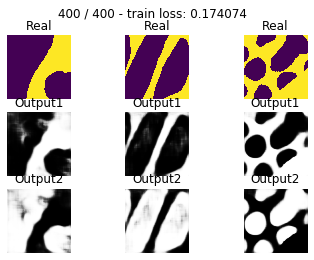

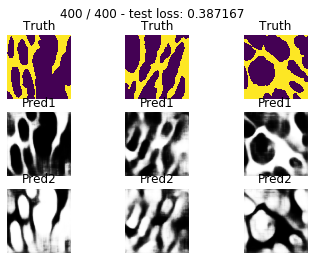

Finished


In [12]:
num_epoch = 400
#iteration_train = int(len(train_data))

#batch_size_test= 6
# iteration_testA = int(len(testsetAraw)/batch_size_test)

train_loss=[]
test_loss=[]
train_loss_store=[]
test_loss_store=[]


torch.cuda.empty_cache()
net.cuda()

# Train loop
for epoch in range(num_epoch):  
    
    train_loss_iter = 0.0
    train_loss_step= 0.0
    print('* Studying Epoch %d/%d' % (epoch+1, num_epoch) + ', Please wait')
    
    net.train()
    
    for i,traindata in enumerate(train_loader):
        #Generate data from batch generator
        train_images,train_annos_bg = traindata
       
        
        #Transfrom data type
        # train_image_torch = torch.from_numpy(train_image)
        # train_annos_torch = torch.from_numpy(train_annos_bg)
        train_annos_db = train_annos_bg.float()
        # train_annos = train_annos_db.permute(0,3,1,2)

        #train network
        optimizer.zero_grad()
        out_train = net(train_images.cuda())

        #Loss & Optimizer
        train_loss_step = criterion(out_train, train_annos_db.cuda())
        train_loss_step.backward()
        optimizer.step()
        
        train_loss_iter += float(train_loss_step.item())
   
    clear_output(wait=True)
    train_step= i+1
    train_loss_epoch= train_loss_iter/train_step
    train_loss_store.append(float(train_loss_epoch))
    torch.cuda.empty_cache()
    print('-- Train Loss: %f' % float(train_loss_epoch))

# Test loop
# for epoch in range(num_epoch): 
    net.eval()
    test_loss_step =0.0
    test_loss_iter =0.0

    for i,vaildata in enumerate(vail_loader):
        #torch.no_grad
        vail_image, vail_annos_bg = vaildata
     

        vail_image = vail_image.float()
        vail_annos_db =vail_annos_bg.float()

        out_vail=net(vail_image.cuda())
        # print('test',out_test)
        test_loss_step = criterion(out_vail, vail_annos_db.cuda())
        test_loss_iter += float(test_loss_step.item())

    clear_output(wait=True)
    test_step= i+1
    test_loss_epoch = test_loss_iter/test_step
    test_loss_store.append(test_loss_epoch)
    torch.cuda.empty_cache()
    print(' -- Test Loss: %f' % test_loss_epoch)

 
#print the results
    Y_hat_train= out_train.detach().cpu()
    Y_hat_test = out_vail.detach().cpu()

    imshow_train= train_annos_bg.permute(0,2,3,1)

    outshow_train=Y_hat_train.permute(0,2,3,1)
 
    imshow_test= vail_annos_bg.permute(0,2,3,1)
    outshow_test=Y_hat_test.permute(0,2,3,1)  

    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(imshow_train[k,:,:,0])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(outshow_train[k,:,:,0].detach().numpy(), cmap='gray')
        plt.title('Output1')
        plt.axis('off')
        plt.subplot(3,3,k+7)
        plt.imshow(outshow_train[k,:,:,1].detach().numpy(), cmap='gray')
        plt.title('Output2')
        plt.axis('off')
    plt.suptitle('%d / %d - train loss: %f' % (epoch+1, num_epoch, train_loss_epoch))
    plt.show()
    
    k=0
    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(imshow_test[k,:,:,0])
        plt.title('Truth')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(outshow_test[k,:,:,0].detach().numpy(), cmap='gray')
        plt.title('Pred1')
        plt.axis('off')
        plt.subplot(3,3,k+7)
        plt.imshow(outshow_test[k,:,:,1].detach().numpy(), cmap='gray')
        plt.title('Pred2')
        plt.axis('off')
    plt.suptitle('%d / %d - test loss: %f' % (epoch+1, num_epoch, test_loss_epoch))
    plt.show()


print('Finished')

In [0]:
#print(out_train)

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

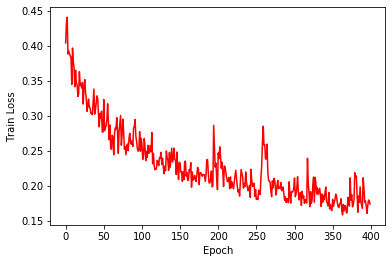

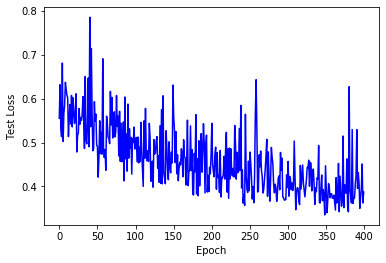

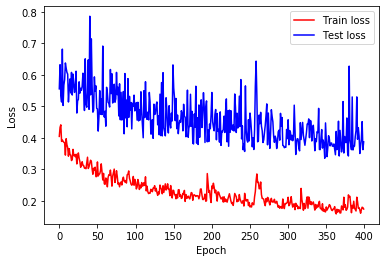

In [13]:
epoch = np.arange(len(test_loss_store))
plt.figure()
plt.plot(epoch, train_loss_store, 'r')
plt.xlabel('Epoch'), plt.ylabel('Train Loss')

plt.figure()
plt.plot(epoch, test_loss_store, 'b')
plt.xlabel('Epoch'), plt.ylabel('Test Loss')

epoch = np.arange(len(test_loss_store))
plt.figure()
plt.plot(epoch, train_loss_store, 'r', epoch, test_loss_store, 'b')
plt.legend(['Train loss','Test loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

In [0]:
test_data = Custom_Data_test(raw_img_testB_location, anno_img_testB_location)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

pred=[]
true=[]
for i,test_data in enumerate(test_loader):
    test_images,test_annos=test_data
  #  print(test_annos.shape)
    test_images=test_images.float()
   # test_annos=test_annos.float()
    pred_temp=net(test_images.cuda())
    pred.append(pred_temp)
    true.append(test_annos)
#print(pred[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


F1 score for gland is 0.8124132447770043


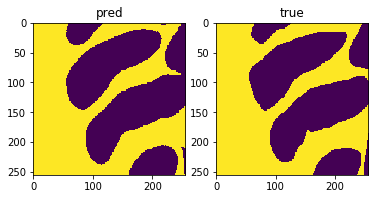

In [17]:
from sklearn.metrics import f1_score

prediction = []
#temp = pred
#temp = temp.permute(0,2,3,1)
dataset='gland'
score_path='/content/drive/My Drive/Gland_SegNet/testB'
f1=0
#plt.imshow(temp[0,:,:,0].detach().numpy())
for i in range(len(pred)):
    temp2 = pred[i]
    
    temp_annos = true[i]
    
    temp2 = temp2.permute(0,2,3,1)
    temp2 = temp2.reshape(((imgsize_w,imgsize_w,2)))
    temp_annos = temp_annos.permute(0,2,3,1)
    temp_annos = temp_annos.reshape(((imgsize_w,imgsize_w,2)))

 #   temp2 = transforms.ToPILImage(mode='LA')
#     prediction.append(temp)
    
    os.path.join('/content/drive/My Drive/Colab Notebooks/testB/prediction/',str(i),'.jpg')
    new_image = temp2[:,:,0].cpu().detach().numpy()
    new_annos = temp_annos[:,:,0].cpu().detach().numpy()
    new_image[new_image>=0.5]=1
    new_image[new_image<0.5]=0
  #  print(new_image)
    plt.subplot(1,2,1)
    plt.imshow(new_image)
    plt.title('pred')
    plt.subplot(1,2,2)
    plt.imshow(new_annos)
    plt.title('true')
    y_true=new_annos

    y_pred=new_image

    f1 += f1_score(y_true.reshape(-1), y_pred.reshape(-1), average='macro')

f1 /= len(pred)

f = open(score_path+"/f1_score.txt", "w")

f.write("The f1 score is : {0}".format(f1))

f.close()

print("F1 score for {0} is {1}".format(dataset, f1))